# WiDS 2019 Datathone revisited: 
## Binary classification of oil palm satellite images
##  Image augmentation for class balancing and transfer learning using Keras API

In [0]:
# Includes the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import os

from keras import layers
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, History 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras import applications
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import multiprocessing


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score


import sys, os
sys.path.insert(0, '../')
from oilpalm import OilPalmImages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

Using TensorFlow backend.


In [0]:
# --- Check if Tensorflow is using GPU (install tensorflow-gpu istead of tensorflow)
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


#create an instance from OilPalmImages
## Get labels according to the selection criterion and the label confidence

plot the distribution of the score value for each of the classes...


/home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


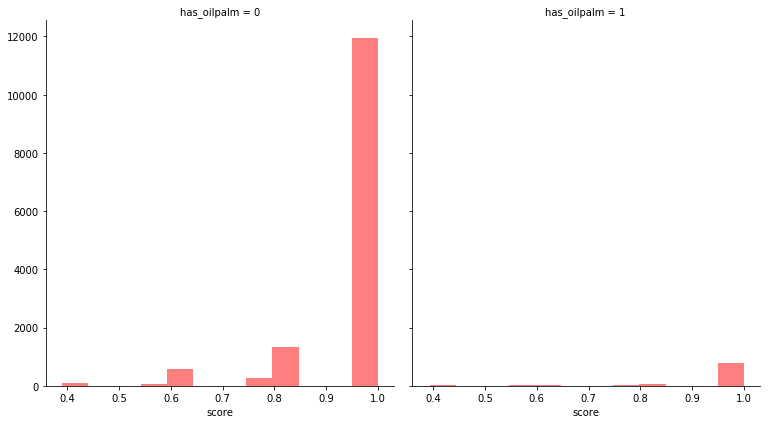

plot the histogram of classes of the training samples...


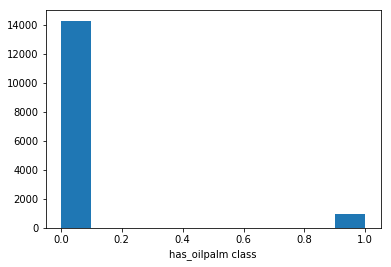

In [0]:
#---- create instance of OilPalmImages 
train_file_directory = "train_images/"
labels_file_name = 'traininglabels.csv'
# --- use the label confidence (probability) assigned when labeling to select the labels/images, hard  
label_selection_probability = 0.5 # confidence (probability) threshold for accepting the assigned label
label_selection_method = 'soft' # or 'hard' threshold 
apply_pca = False
reduced_image_height = 256
max_samples_class0 = 1005
max_samples_class1 = 1003
op_instance = OilPalmImages(file_directory= train_file_directory, labels_file_name = labels_file_name, apply_pca = apply_pca,
                            pca_components= reduced_image_height, label_selection_probability = label_selection_probability, 
                            label_selection_method = label_selection_method,  max_samples_class0 = max_samples_class0,
                            max_samples_class1 =max_samples_class1)
#---- For Keras, we will only get the labels from file, we will not use the custom readImages member method
op_instance.get_labels_from_file()

## create data frame for the image file names and their labels

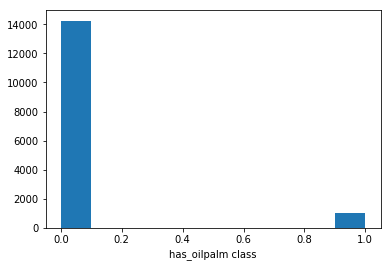

0    14241
1     1003
Name: img_label, dtype: int64


,img_filename,img_label
0,img_000002017.jpg,0
1,img_000012017.jpg,0
2,img_000022017.jpg,0
3,img_000072017.jpg,0
4,img_000082017.jpg,0
5,img_000092017.jpg,0
6,img_000102017.jpg,0
7,img_000112017.jpg,0
8,img_000132017.jpg,0
9,img_000142017.jpg,0


In [0]:
df_labels = pd.DataFrame()
df_labels['img_filename'] = op_instance.labels_dic.keys()
df_labels['img_label'] = list(map(lambda x: op_instance.get_label_forImage(x), op_instance.labels_dic.keys()))

plt.hist(df_labels.img_label.values)
plt.xlabel('has_oilpalm class')
plt.show()
df_labels['img_label'] = df_labels['img_label'].astype(str)
print("Available labeled data balance in the raw data")
print(df_labels.img_label.value_counts())

df_labels.head(10)

#Prepare the data for training
## Train- Test split 80%- 20%

In [0]:
#--- split the labeled data into train and test set
train_df, test_df = train_test_split(df_labels,train_size = 0.80, test_size = 0.20 , random_state=1 )
train_df= train_df.reset_index(drop=True)
test_df= test_df.reset_index(drop=True)
print("Train data balance before augmentation")
print(train_df.img_label.value_counts())
train_df.tail(10)

0    11381
1      814
Name: img_label, dtype: int64


,img_filename,img_label
12185,img_002262017.jpg,0
12186,img_073462017.jpg,0
12187,img_041492017.jpg,0
12188,img_004092018.jpg,0
12189,img_050212018.jpg,0
12190,img_013262017.jpg,0
12191,img_075642017.jpg,0
12192,img_067662018.jpg,0
12193,img_003712017.jpg,0
12194,img_085582018.jpg,0


## Upsampling the minority class using image augmentation 

In [0]:
#------ balance the data by upsampling the minority class (the augmentation will happen later in generation)
df_train_0 = train_df[train_df.img_label.values =='0']
df_train_1 = train_df[train_df.img_label.values =='1']
aug_df_train =pd.DataFrame()
for i in range(8):
    aug_df_train = aug_df_train.append(df_train_1)
    

aug_df_train = aug_df_train.reset_index(drop = True)

train_df = aug_df_train.append(df_train_0)
train_df = train_df.reset_index(drop = True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
print("Train data balance after augmentation")
train_df.img_label.value_counts()

0    11381
1     6512
Name: img_label, dtype: int64

In [0]:
# Optimization parameters
lr = 0.1 # learning rate
momentum = 0.9 # momentum
epochs = 10 # total epochs
decay_rate = 0.1 / epochs # rate at which learning rate is decreased
batch_size = 32

In [0]:
#---- Create train generator split the training data into train and validation 
#sets and randomly augmeneted the training/validation images using Keras's ImageDataGenerator
datagen=ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            #rescale=1./255, # this messes up the order later in prediction
                            shear_range=0.2,
                            zoom_range=0.2,
                            brightness_range=[0.5, 1.5],
                            vertical_flip = True,
                            horizontal_flip=True,
                            channel_shift_range = 0.2,
                            fill_mode='nearest',
                            validation_split=0.25)
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./train_images/",
x_col="img_filename",
y_col="img_label",
subset="training",
target_size=(256, 256),
color_mode='rgb',
batch_size=batch_size,
#save_to_dir = "./augmented_train_images/", #uncomment this if you want to save the resulting augmented images
#save_prefix='', save_format='jpg',
seed=42,
shuffle=False, # if True, it will mess up the order later in prediction
class_mode="categorical",
drop_duplicates= False)

valid_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./train_images/",
x_col="img_filename",
y_col="img_label",
subset="validation",
target_size=(256, 256),
color_mode='rgb',
batch_size=batch_size,
seed=42,
shuffle=False,  # if True, it will mess up the order later in prediction
#save_to_dir = "./augmented_valid_images/",  #uncomment this if you want to save the resulting augmented images
#save_prefix='', save_format='jpg',    
class_mode="categorical",
drop_duplicates= False)

datagen_test=ImageDataGenerator()

test_generator=datagen_test.flow_from_dataframe(
dataframe=test_df,
directory="./train_images/",
x_col="img_filename",
y_col="img_label",
target_size=(256, 256),
color_mode='rgb',
batch_size=batch_size,
seed=42,
shuffle=False,  # if True, it will mess up the order later in prediction
class_mode="categorical")

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("number of training samples ", train_generator.n)
print("number of validation samples ", valid_generator.n)
print("number of testing samples ", test_generator.n)
print("number of positive/negative training samples ")
y_train = train_generator.classes
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)
y_valid = valid_generator.classes
print("number of positive/negative validation samples ")
unique, counts = np.unique(y_valid, return_counts=True)
print(unique)
print(counts)

y_test = test_generator.classes
print("number of positive/negative test samples ")
unique, counts = np.unique(y_test, return_counts=True)
print(unique)
print(counts)
print("STEP_SIZE_TRAIN ", STEP_SIZE_TRAIN)
print("STEP_SIZE_VALID", STEP_SIZE_VALID)
print("STEP_SIZE_TEST", STEP_SIZE_TEST)

Found 13420 validated image filenames belonging to 2 classes.
Found 4473 validated image filenames belonging to 2 classes.
Found 3049 validated image filenames belonging to 2 classes.
number of training samples  13420
number of validation samples  4473
number of testing samples  3049
number of positive/negative training samples 
[0 1]
[8487 4933]
number of positive/negative validation samples 
[0 1]
[2894 1579]
number of positive/negative test samples 
[0 1]
[2860  189]
STEP_SIZE_TRAIN  419
STEP_SIZE_VALID 139
STEP_SIZE_TEST 95


## Generator for the hold-out test set (unlabeled)

In [0]:
file_names = os.listdir("./leaderboard_test_data/")
hold_df = pd.DataFrame()
hold_df["img_filename"] = file_names
hold_df.head(10)

,img_filename
0,img_101862018.jpg
1,img_067962017.jpg
2,img_063002017.jpg
3,img_096162017.jpg
4,img_047432018.jpg
5,img_031932018.jpg
6,img_010552017.jpg
7,img_046482017.jpg
8,img_039142018.jpg
9,img_085602018.jpg


In [0]:
#--- generator for the holdout test set (groundtruth not available)
datagen_hold=ImageDataGenerator()
hold_generator=datagen_hold.flow_from_dataframe(
dataframe=hold_df,
directory="./leaderboard_test_data/",
x_col="img_filename",
target_size=(256, 256),
color_mode='rgb',
batch_size=1,
seed=42,
shuffle=False,
class_mode=None)

Found 4356 validated image filenames.


In [0]:
#-----get class weight from the training data
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df.img_label),
                                                 train_df.img_label)

In [0]:
class_weight

array([0.78609085, 1.37384828])

## CNN Model: use ResNet as a base model and add two output layers to be fitted by the trained data

In [0]:
#--- base model on ResNet, remove top layer
base_model=applications.resnet50.ResNet50(weights='imagenet',include_top=False, input_shape =(256,256,3), classes=2)

W0718 07:57:30.103055 140193772812096 deprecation_wrapper.py:119] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 07:57:30.110625 140193772812096 deprecation_wrapper.py:119] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 07:57:30.114632 140193772812096 deprecation_wrapper.py:119] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0718 07:57:30.129504 140193772812096 deprecation_wrapper.py:119] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name t

In [0]:
# add two layers over the base model
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.2)(x)
# # let's add a fully-connected layer
#
x = Dense(200, activation='tanh')(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.4)(x)
# and a logistic layer with two output classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=SGD(lr=lr, momentum=momentum, decay=decay_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
# model.compile(optimizer='rmsprop',loss='binary_crossentropy',
#               metrics=['accuracy'])    

W0718 07:57:35.740801 140193772812096 deprecation.py:506] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0718 07:57:35.826035 140193772812096 deprecation_wrapper.py:119] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
#---number of available CPUs 
multiprocessing.cpu_count()

8

In [0]:
class_weight2 =class_weight.copy()
# class_weight2[1] = class_weight2[1]*2
# transform the class weight to dictionary
weight_dic = dict()
weight_dic[0] = class_weight2[0]
weight_dic[1] = class_weight2[1]
weight_dic

In [0]:
# Fit the model
MODEL_FILE = 'filename.model'

num_used_cpu = 2
num_epochs = epochs
history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch= STEP_SIZE_TRAIN,
                                          epochs=num_epochs,
                                          verbose=1,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          class_weight = weight_dic)
                                          #workers=num_used_cpu,
#                                           max_queue_size=32,use_multiprocessing=True)

model.save(MODEL_FILE)

W0718 07:57:35.991030 140193772812096 deprecation.py:323] From /home/asamadan/anaconda3/envs/wids_env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
419/419 [==============================] - 202s 481ms/step - loss: 0.3070 - acc: 0.8910 - val_loss: 0.4098 - val_acc: 0.8554
Epoch 2/10
 18/419 [>.............................] - ETA: 2:06 - loss: 0.2672 - acc: 0.9086

## Model evaluation

In [0]:
# Plot the loss function and the evaluation metric over the course of training
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot accuracy
ax.plot(np.array(history.history['acc']), color='blue', label='training accuracy')
# Plot loss
ax.plot(np.array(history.history['loss']), color='red', label='training loss')
ax.set_title('optimizer={}, learning rate={}'.format('Adam', lr))
ax.legend(loc='upper right')
plt.show()

In [0]:
scores = model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)
print("Validation Accuracy = ", scores[1])

In [0]:
train_scores = model.evaluate_generator(generator=train_generator,
steps=STEP_SIZE_TRAIN)
print("Train Accuracy = ", train_scores[1])

In [0]:
test_generator.reset()
test_scores = model.evaluate_generator(generator=test_generator,
steps=STEP_SIZE_TEST)
print("Test Accuracy = ", test_scores[1])

In [0]:
valid_generator.reset()
y_valid = valid_generator.classes
y_valid_pred = model.predict_generator(valid_generator,valid_generator.n // batch_size+1,use_multiprocessing=False)
y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)

In [0]:
tn, fp, fn, tp = confusion_matrix(y_valid ,y_valid_pred_classes ).ravel()


In [0]:
(tn+tp)/(tn+fp+fn+tp )

In [0]:
unique, counts = np.unique(y_valid, return_counts=True)
print(unique)
print(counts)


In [0]:
test_generator.reset()
y_test = test_generator.classes
y_test_pred = model.predict_generator(test_generator,test_generator.n // batch_size+1,use_multiprocessing=False)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_classes ).ravel()
(tn+tp)/(tn+fp+fn+tp )

In [0]:
train_generator.reset()
y_train = train_generator.classes
y_train_pred = model.predict_generator(train_generator,train_generator.n // batch_size+1,use_multiprocessing=False)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# print('Train ROC:', roc_auc_score(y_train, y_train_pred))
# y_pred[y_pred > 0.5] = 1
# y_pred[y_pred <= 0.5] = 0
# Compute the confusion matrix on the training set
print('Train confusion matrix:\n', confusion_matrix(y_train,y_train_pred_classes), '\n\n')

In [0]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred_classes).ravel()
                                   

In [0]:
(tn+tp)/(tn+fp+fn+tp )

In [0]:
# Compute the ROC on the training set
# print('Valid ROC:', roc_auc_score(y_valid, y_valid_pred))
# y_pred[y_pred > 0.5] = 1
# y_pred[y_pred <= 0.5] = 0
# Compute the confusion matrix on the training set
print('Validation confusion matrix:\n', confusion_matrix(y_valid,y_valid_pred_classes), '\n\n')



# Get the class probabilities predicted by our MLP on the test set
# y_pred = cnn_model.predict(X_test.reshape((-1, op_instance.height, op_instance.width, 1)))
# Compute the ROC on the test set
# print('Test ROC:', roc_auc_score(y_test, y_test_pred))
# Compute the confusion matrix on the test set
# y_pred[y_pred > 0.5] = 1
# y_pred[y_pred <= 0.5] = 0
print('Test confusion matrix:\n', confusion_matrix(y_test, y_test_pred_classes))

In [0]:
plt.matshow(confusion_matrix(y_train, y_train_pred_classes))
plt.title('Training confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.matshow(confusion_matrix(y_valid, y_valid_pred_classes))
plt.title('Validation confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.matshow(confusion_matrix(y_test, y_test_pred_classes))
plt.title('Testing confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Predict the existance of palm oil plantation in holdout test set and save the output to csv file

In [0]:
hold_generator.reset()
y_hold_pred = model.predict_generator(hold_generator,hold_generator.n // 1,use_multiprocessing=False)
y_hold_pred_classes = np.argmax(y_hold_pred, axis=1)

In [0]:

test_res = pd.DataFrame()
test_res['image_id'] = hold_generator.filenames
test_res['has_oilpalm'] = y_hold_pred_classes
test_res.to_csv('test_results_wids.csv', index=False)
